# totalVI for cross-modality prediction on NeurIPS data

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import os
from self_supervision.paths import MULTIMODAL_FOLDER

Download and preprocess the NeurIPS Cite-Seq / NeurIPS Multimodal data into MULTIMODAL_FOLDER

In [2]:
adata = sc.read_h5ad(os.path.join(MULTIMODAL_FOLDER, "NeurIPS_filtered_hvg_adata.h5ad"))
adata


AnnData object with n_obs × n_vars = 90261 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [3]:
train_adata = adata[adata.obs['split'] == 'train']
test_adata = adata[adata.obs['split'] == 'ood_test']

In [4]:
train_adata.X.shape

(63623, 2000)

In [5]:
test_adata

View of AnnData object with n_obs × n_vars = 10465 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [6]:
import numpy as np
from scipy.sparse import issparse

n_proteins = 134  # Number of proteins

# Convert train_adata.X to a dense array if it's sparse
if issparse(train_adata.X):
    train_gene_expression = train_adata.X.toarray()
else:
    train_gene_expression = train_adata.X

# Concatenate gene expression with zeroed-out protein expression for training
train_adata.obsm['modality_concatenated'] = np.concatenate(
    [train_gene_expression, np.zeros((train_adata.shape[0], n_proteins))], axis=1)

# Do the same for the test set
if issparse(test_adata.X):
    test_gene_expression = test_adata.X.toarray()
else:
    test_gene_expression = test_adata.X

test_adata.obsm['modality_concatenated'] = np.concatenate(
    [test_gene_expression, np.zeros((test_adata.shape[0], n_proteins))], axis=1)


In [7]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = train_adata.obs.batch.values.ravel()
train_adata.obs.batch

GCATTAGCATAAGCGG-1-s1d1    s1d1
TACAGGTGTTAGAGTA-1-s1d1    s1d1
GTAGAAAGTGACACAG-1-s1d1    s1d1
TCCGAAAAGGATCATA-1-s1d1    s1d1
CTCCCAATCCATTGGA-1-s1d1    s1d1
                           ... 
TAACTTCAGATACAGT-1-s4d9    s4d9
GAATCACCACGGAAGT-1-s4d9    s4d9
TCGAAGTGTGACAGGT-1-s4d9    s4d9
GCAGGCTGTTGCATAC-1-s4d9    s4d9
ACGTAACAGGTCTACT-1-s4d9    s4d9
Name: batch, Length: 63623, dtype: category
Categories (11, object): ['s1d1', 's1d2', 's1d3', 's2d4', ..., 's3d7', 's4d1', 's4d8', 's4d9']

In [8]:
train_adata.obsm["protein_expression"] = train_adata.obsm["protein_counts"]
test_adata.obsm["protein_expression"] = test_adata.obsm["protein_counts"]

In [9]:
# Use 'modality_concatenated' for model setup
scvi.model.TOTALVI.setup_anndata(
    train_adata, 
    protein_expression_obsm_key="protein_counts",
    layer=None
)

model = scvi.model.TOTALVI(train_adata, latent_distribution="normal")
model.train()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Using column names from columns of adata.obsm['protein_counts']                                           
INFO     Computing empirical prior initialization for protein background.                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 126/126: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [08:25<00:00,  3.91s/it, v_num=1, train_loss_step=885, train_loss_epoch=908]

`Trainer.fit` stopped: `max_epochs=126` reached.


Epoch 126/126: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [08:25<00:00,  4.01s/it, v_num=1, train_loss_step=885, train_loss_epoch=908]


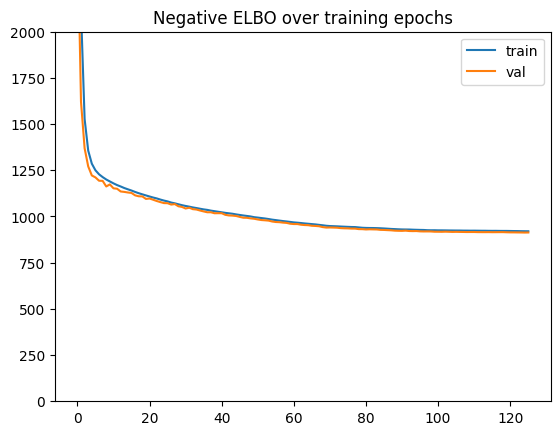

In [10]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(0, 2000)
plt.legend()

In [11]:
# Getting the latent representation
test_adata.obsm["X_totalVI"] = model.get_latent_representation(test_adata)

# Getting denoised protein and gene expression
test_adata.obsm["denoised_proteins"], test_adata.obsm["denoised_genes"] = model.get_normalized_expression(
    test_adata, 
    return_mean=True, 
    n_samples=25
)


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


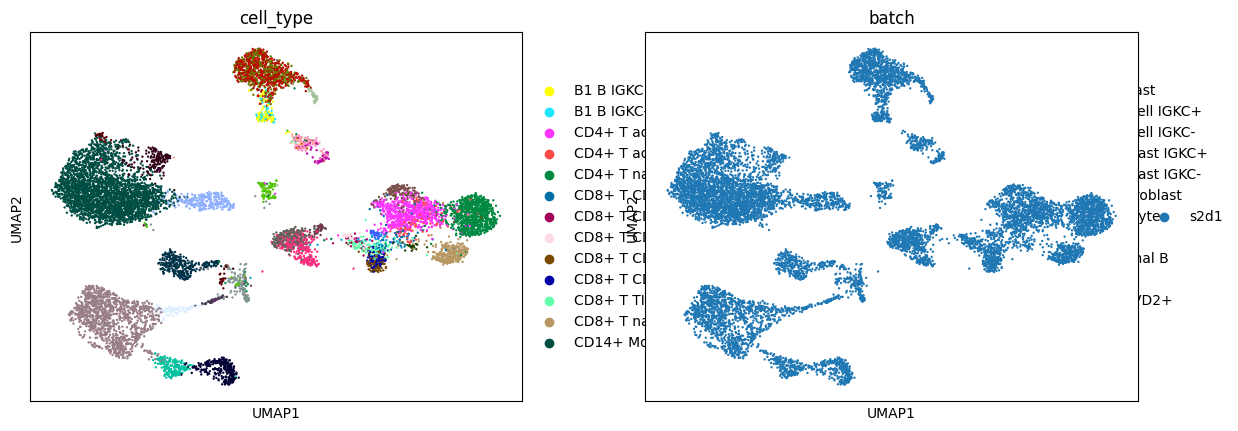

In [12]:
# Visualization using UMAP
sc.pp.neighbors(test_adata, use_rep="X_totalVI")
sc.tl.umap(test_adata)
sc.pl.umap(test_adata, color=["cell_type", "batch"])


In [13]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Assuming test_adata.obsm["protein_counts"] holds the true protein expression data
true_proteins = test_adata.obsm["protein_counts"].to_numpy()

# Getting the model's output for test data
# The output is a tuple with (gene_expression, protein_expression)
_, predicted_proteins_expression = model.get_normalized_expression(
    test_adata,
    return_mean=True,
    n_samples=25
)

# Convert predicted protein expression to numpy array
predicted_proteins = predicted_proteins_expression.values

# Flatten the arrays for Pearson correlation and MSE calculation
true_proteins = true_proteins.flatten()
predicted_proteins = predicted_proteins.flatten()

# Calculate Pearson correlation
pearson_corr, _ = pearsonr(true_proteins, predicted_proteins)
print(f"Pearson Correlation Coefficient: {pearson_corr}")

# Calculate MSE
mse = mean_squared_error(true_proteins, predicted_proteins)
print(f"Mean Squared Error: {mse}")


Pearson Correlation Coefficient: 0.9405111058052975
Mean Squared Error: 294.848388671875
